In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler
pd.options.mode.chained_assignment = None 
import gender_guesser.detector as gender
d=gender.Detector(case_sensitive=False)

In [2]:
raw_train=pd.read_csv('train.csv')
raw_test=pd.read_csv('test.csv')
train=raw_train[:]
test=raw_test[:]

In [3]:
def cabin_separation(df):
    
    df['CabinDeck'] = df['Cabin'].str.split('/', expand=True)[0]
    df['CabinNum']  = df['Cabin'].str.split('/', expand=True)[1]
    df['CabinSide'] = df['Cabin'].str.split('/', expand=True)[2]
    
    df.drop(columns = ['Cabin'], inplace = True)
    return df

train=cabin_separation(train)
test=cabin_separation(test)

In [4]:
cols=list(train.columns)
cols.remove('Transported')

In [5]:
def logic(df, age_limit = 18):
    df['RoomService'] = np.where(df['Age'] < age_limit, 0, df['RoomService'])
    df['FoodCourt'] = np.where(df['Age'] < age_limit, 0, df['FoodCourt'])
    df['ShoppingMall'] = np.where(df['Age'] < age_limit, 0, df['ShoppingMall'])
    df['Spa'] = np.where(df['Age'] < age_limit, 0, df['Spa'])
    df['VRDeck'] = np.where(df['Age'] < age_limit, 0, df['VRDeck'])

    df['RoomService'] = np.where(df['CryoSleep'] == True, 0, df['RoomService'])
    df['FoodCourt'] = np.where(df['CryoSleep'] == True, 0, df['FoodCourt'])
    df['ShoppingMall'] = np.where(df['CryoSleep'] == True, 0, df['ShoppingMall'])
    df['Spa'] = np.where(df['CryoSleep'] == True, 0, df['Spa'])
    df['VRDeck'] = np.where(df['CryoSleep'] == True, 0, df['VRDeck'])
    
    return df

train=logic(train)
test=logic(test)

In [6]:
imputer_a = SimpleImputer(strategy='most_frequent')
imputer_b = SimpleImputer(strategy='median')
scaler = StandardScaler()

for i in cols:
    if(train[i].dtype!=np.int64 and train[i].dtype!=np.float64 and train[i].dtype!=np.bool_):
        train[i]=imputer_a.fit_transform(train[[i]]).ravel()
        test[i]=imputer_a.transform(test[[i]]).ravel()
    elif(train[i].dtype!=np.bool_):
        train[i]=imputer_b.fit_transform(train[[i]]).ravel()
        train[i]=scaler.fit_transform(train[[i]]).ravel()
        test[i]=imputer_b.transform(test[[i]]).ravel()
        test[i]=scaler.transform(test[[i]]).ravel()
    if(train[i].dtype==np.bool_):
        train[i]=train[i]*1
        test[i]=test[i]*1
        

train.CryoSleep=train['CryoSleep'].astype(int)
train.VIP=train['VIP'].astype(int)
train.Transported=train.Transported*1
test.CryoSleep=test['CryoSleep'].astype(int)
test.VIP=test['VIP'].astype(int)

In [7]:
def total_billed(df):
    df['TotalBilled'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    return df

train=total_billed(train)
test=total_billed(test)

In [8]:
train['FirstName']=[x.partition(' ')[0] for x in train.Name]
train['Gender']=[d.get_gender(x) for x in train.FirstName]
train.drop(columns = ['FirstName'], inplace = True)
test['FirstName']=[x.partition(' ')[0] for x in test.Name]
test['Gender']=[d.get_gender(x) for x in test.FirstName]
test.drop(columns = ['FirstName'], inplace = True)

In [9]:
cab=train.loc[:,['CabinNum','Transported']]
cab=cab.groupby('CabinNum', as_index=False).agg(lambda x: sum(x)/len(x))
cab=cab.loc[(cab['Transported']<0.05) | (cab['Transported']>0.95)]

In [10]:
X=train.drop(['Transported','PassengerId','Name','CabinNum'],axis=1)
X=pd.get_dummies(X,columns=['HomePlanet','Destination','CabinDeck','CabinSide','Gender'])
Y=train.Transported
X_t=test.drop(['PassengerId','Name','CabinNum'],axis=1)
X_t=pd.get_dummies(X_t,columns=['HomePlanet','Destination','CabinDeck','CabinSide','Gender'])

In [11]:
len(tf.config.list_physical_devices('GPU'))

1

In [12]:
model = keras.Sequential([
        layers.Dense(600, activation='relu', input_shape=(X.shape[-1],), bias_regularizer=keras.regularizers.L2(0.002)),
        layers.Dropout(0.25),
        layers.BatchNormalization(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.15),
        layers.BatchNormalization(),
        layers.Dense(50, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(25, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])
    
metrics = [
    'accuracy',
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0002), loss="binary_crossentropy",metrics=metrics)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-10 07:22:02.701063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-10 07:22:02.701438: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
history=model.fit(X,Y,epochs=25,validation_split = 0.1,batch_size=100,shuffle=True)

Epoch 1/25


2022-06-10 07:22:03.409689: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-10 07:22:04.358824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.6863 - precision: 0.6959 - recall: 0.6788

2022-06-10 07:22:09.824027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 7s 33ms/step - loss: 0.5966 - accuracy: 0.6863 - precision: 0.6959 - recall: 0.6788 - val_loss: 0.6312 - val_accuracy: 0.6575 - val_precision: 0.5806 - val_recall: 0.9581
Epoch 2/25
79/79 [==============================] - 2s 25ms/step - loss: 0.4918 - accuracy: 0.7604 - precision: 0.7671 - recall: 0.7586 - val_loss: 0.5692 - val_accuracy: 0.7506 - val_precision: 0.6925 - val_recall: 0.8374
Epoch 3/25
79/79 [==============================] - 2s 27ms/step - loss: 0.4695 - accuracy: 0.7711 - precision: 0.7777 - recall: 0.7689 - val_loss: 0.5202 - val_accuracy: 0.7690 - val_precision: 0.7223 - val_recall: 0.8202
Epoch 4/25
79/79 [==============================] - 2s 25ms/step - loss: 0.4599 - accuracy: 0.7703 - precision: 0.7746 - recall: 0.7724 - val_loss: 0.4810 - val_accuracy: 0.7828 - val_precision: 0.7374 - val_recall: 0.8300
Epoch 5/25
79/79 [==============================] - 2s 24ms/step - loss: 0.4488 - accuracy: 0.7817 - precision: 0.7833 

In [14]:
model.evaluate(X,Y)

272/272 [==============================] - 2s 8ms/step - loss: 0.3752 - accuracy: 0.8165 - precision: 0.8278 - recall: 0.8026


[0.37522172927856445,
 0.816519021987915,
 0.8277974128723145,
 0.8026496171951294]

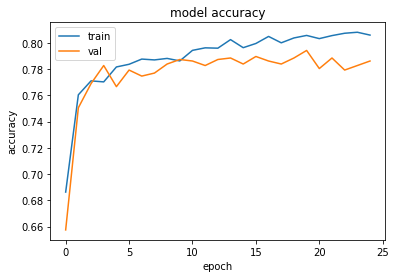

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

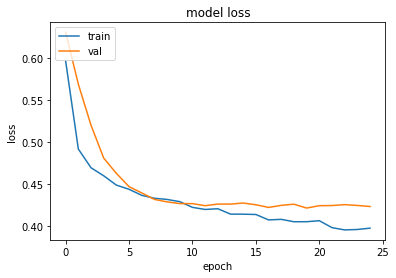

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
Y_t = pd.DataFrame(raw_test.PassengerId)
Y_t['Transported'] = model.predict(X_t) > 0.5
Y_t.to_csv('pred11.csv',index=False)

2022-06-10 07:22:58.752970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
